In [107]:
import re, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable


def parse_block(block):
    pat = (r'chA:\s*(\d+)\s*chB:\s*(\d+).*?'
           r'MNR:\s*([\d.]+)\s*GNR:\s*([\d.]+)\s*DICE:\s*([\d.]+)')
    rows = re.findall(pat, block)
    df = pd.DataFrame(rows, columns=['chA','chB','MNR','GNR','DICE'])
    df = df.astype({'chA':int,'chB':int,'MNR':float,'GNR':float,'DICE':float})
    return df


def plot_metric(avg, channel_names, metric, ax):
    N = len(channel_names)

    upper_mask = np.triu(np.ones_like(avg, dtype=bool), 1)
    lower_mask = np.tril(np.ones_like(avg, dtype=bool), -1)

    cmap_blue = plt.cm.Blues.with_extremes(bad=(1, 1, 1, 0))
    cmap_red  = plt.cm.Reds.with_extremes(bad=(1, 1, 1, 0))

    upper = np.ma.masked_where(~upper_mask, 1 - avg)
    lower = np.ma.masked_where(~lower_mask,     avg)

    im1 = ax.imshow(upper, cmap=cmap_blue, vmin=0, vmax=1, interpolation='none')
    im2 = ax.imshow(lower, cmap=cmap_red,  vmin=0, vmax=1, interpolation='none')

    missing = np.isnan(avg).copy()
    np.fill_diagonal(missing, False)
    overlay = np.ma.masked_where(~missing, np.zeros_like(avg))
    ax.imshow(overlay, cmap=ListedColormap([(0.95, 0.95, 0.95, 1.0)]),
              vmin=0, vmax=1, interpolation='none')

    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            if np.isnan(avg[i, j]):
                ax.text(j, i, '-', ha='center', va='center',
                    fontsize=9, color='#666666')
                continue
            txt = avg[i, j] if i > j else 1 - avg[i, j]
            ax.text(j, i, f'{txt:.3f}', ha='center', va='center', fontsize=9)

    ax.set_xticks(range(N));  ax.set_yticks(range(N))
    ax.set_xticklabels(channel_names, rotation=45, ha='right')
    ax.set_yticklabels(channel_names)
    ax.set_title(metric)

    return im1, im2


def compute_avg_metrics(dfs, channel_names, metrics):
    id2pos = {cid: pos for pos, cid in enumerate(range(len(channel_names)))}
    N = len(channel_names)
    avg_vals = {m: np.full((N, N), np.nan) for m in metrics}

    for m in metrics:
        sums = np.zeros((N, N))
        counts = np.zeros((N, N))
        for df in dfs:
            for _, r in df.iterrows():
                if r.chA in id2pos and r.chB in id2pos:
                    i, j = id2pos[r.chA], id2pos[r.chB]
                    sums[i, j] += r[m]; sums[j, i] += r[m]
                    counts[i, j] += 1; counts[j, i] += 1
        avg = np.divide(sums, counts, out=np.full_like(sums, np.nan), where=counts > 0)
        np.fill_diagonal(avg, np.nan)
        avg_vals[m] = avg

    return avg_vals



In [108]:
channel_names = ['ORB','AKAZE','BRISK', 'KAZE', 'SIFT', 'SuperPoint']  # 0‒5 [ORB,AKAZE,BRISK,KAZE,SIFT,SuperPoint]
metrics= ['MNR','GNR','DICE']

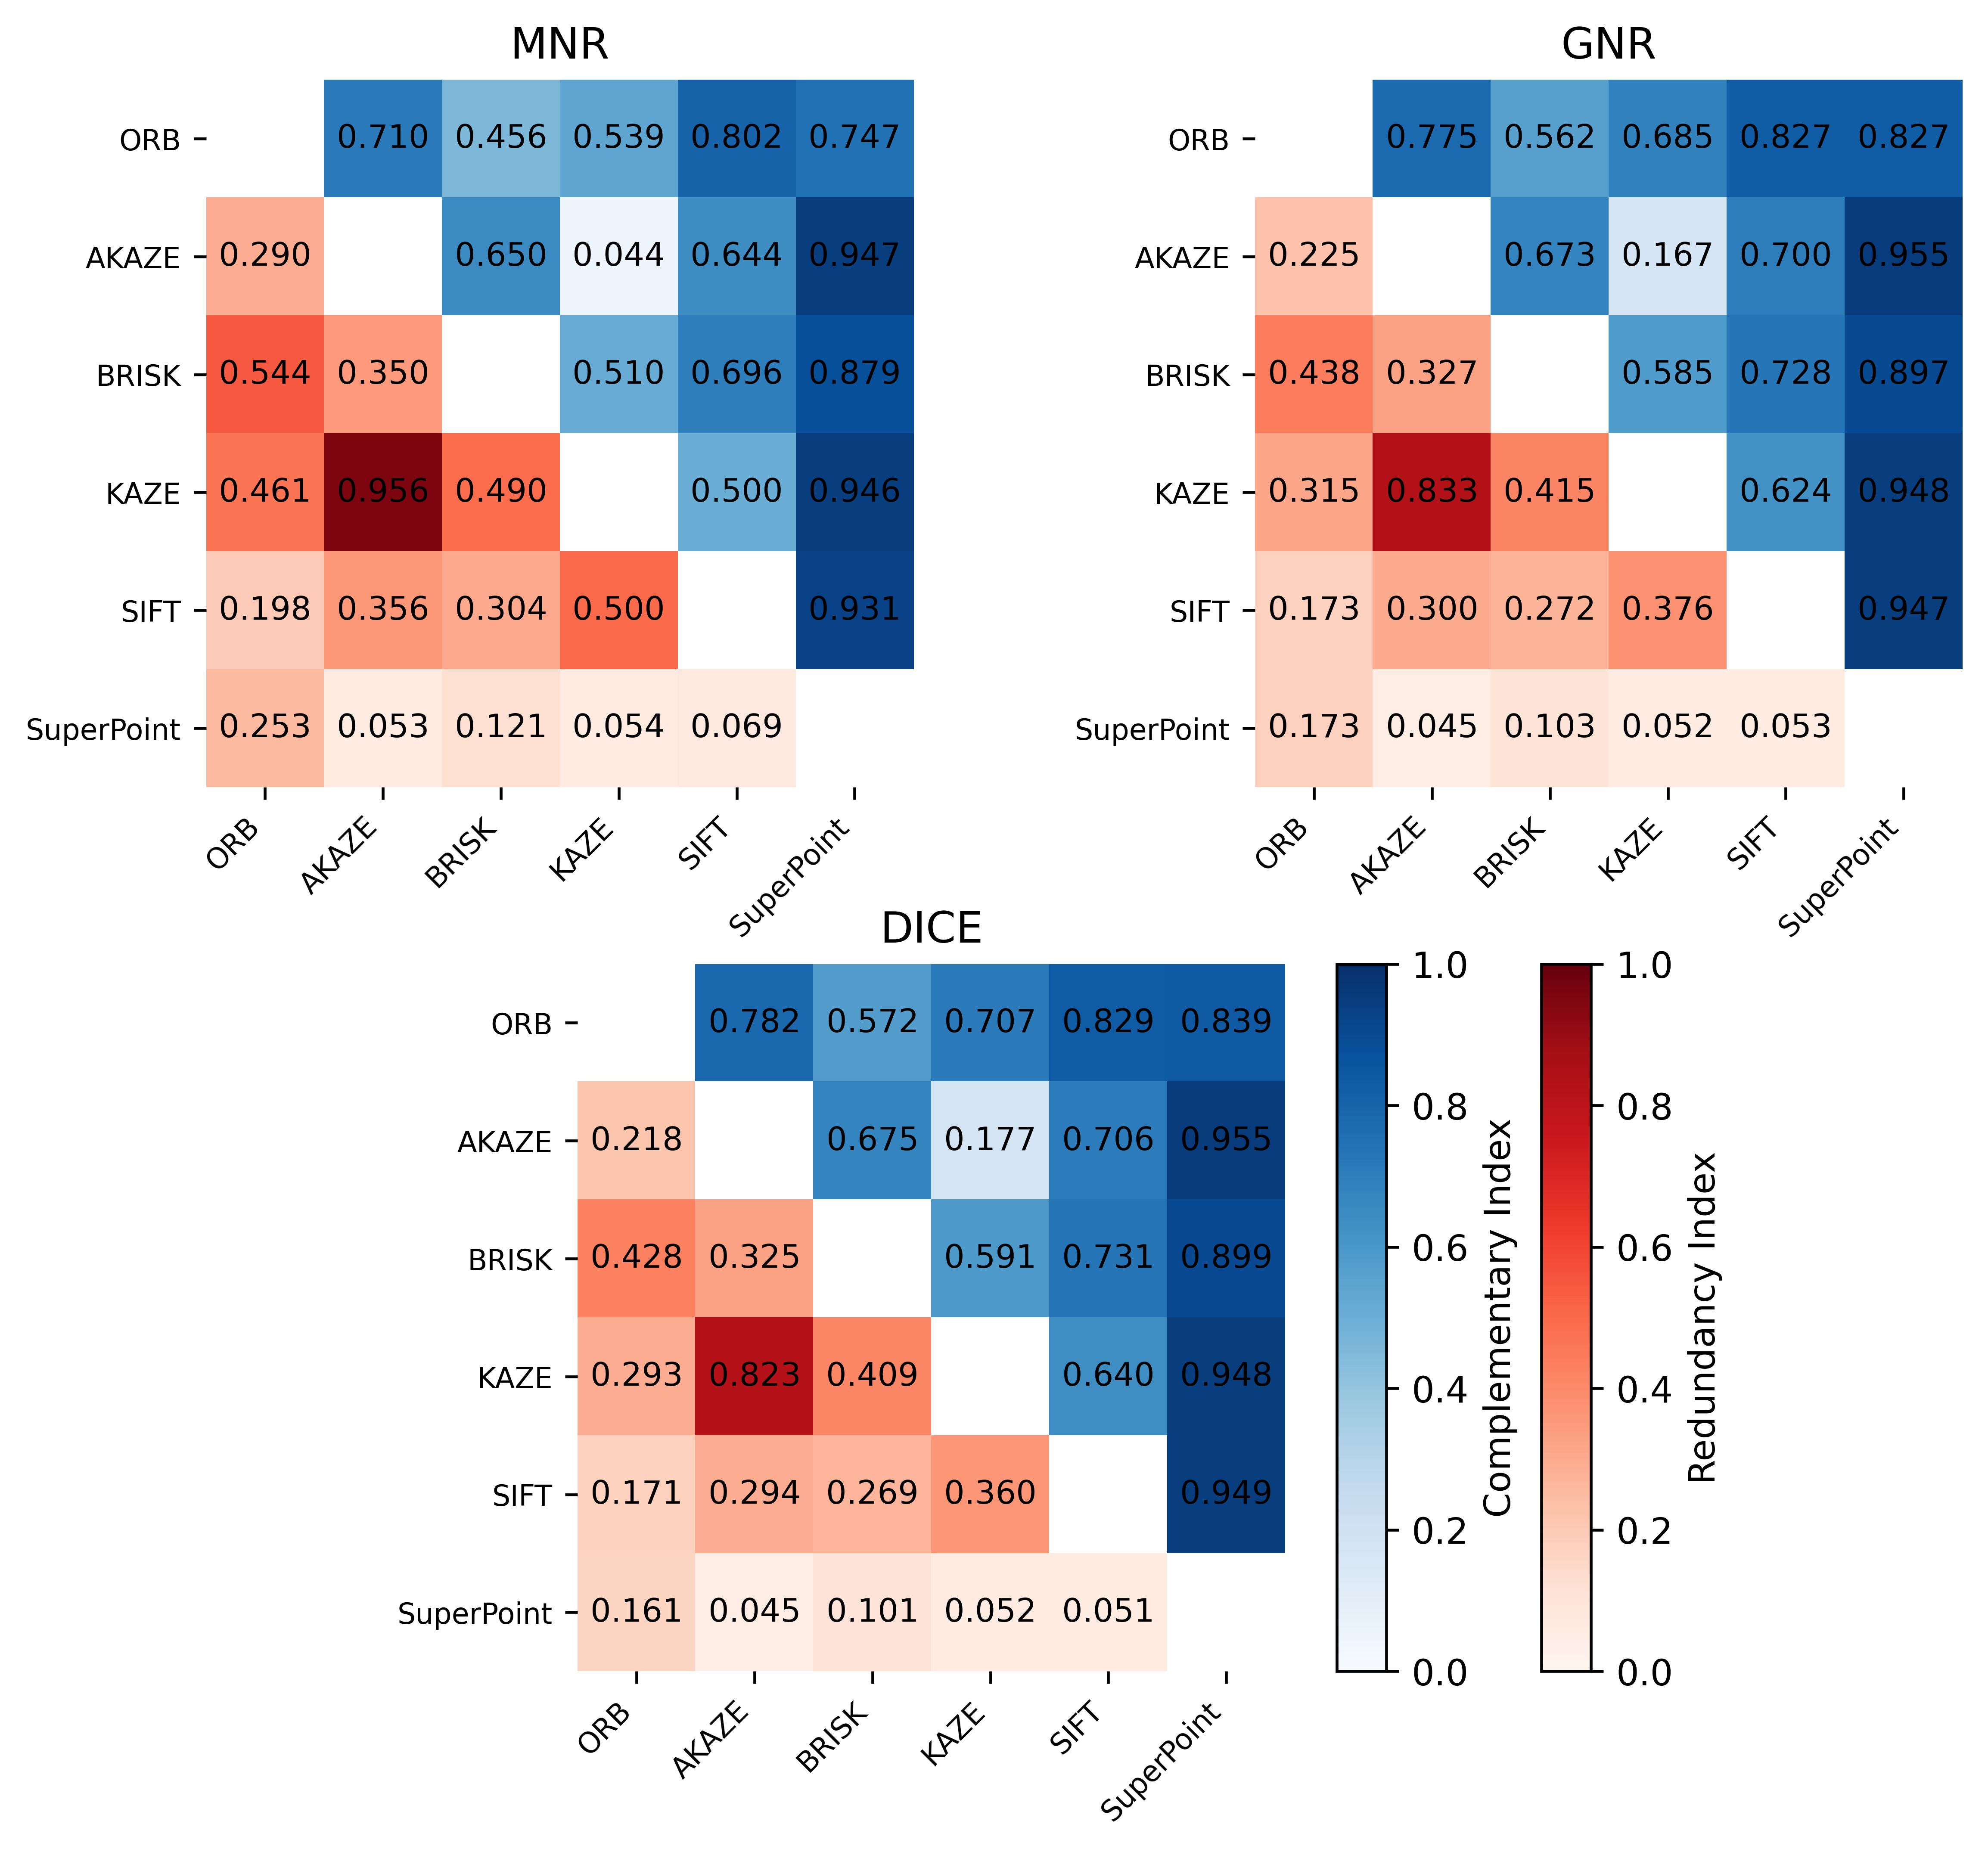

In [109]:
RAW_FILE = 'Correlations/corr_exp_fr1_corr.txt'
OUT_DIR  = Path('ResultFigs')
OUT_DIR.mkdir(exist_ok=True)

with open(RAW_FILE, 'r', encoding='utf-8') as f:
    txt = f.read()

blocks = re.split(r'#\s*-+\s*\d+\s*Per-Channel Summary\s*-+\s*', txt)[1:]
dfs = [parse_block(b) for b in blocks]

avg_vals = compute_avg_metrics(dfs, channel_names, metrics)

ims_red, ims_blue = [], []

fig = plt.figure(figsize=(10, 8), dpi=600)
gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 1.0], hspace=0.25, wspace=0.10)

ax_mnr  = fig.add_subplot(gs[0, 0])
ax_gnr  = fig.add_subplot(gs[0, 1])
ax_dice = fig.add_subplot(gs[1, :])

for ax, m in [(ax_mnr, 'MNR'), (ax_gnr, 'GNR'), (ax_dice, 'DICE')]:
    ax.grid(False)
    ax.set_frame_on(False)
    im_blue, im_red = plot_metric(avg_vals[m], channel_names, m, ax)
    ims_blue.append(im_blue)
    ims_red.append(im_red)

divider  = make_axes_locatable(ax_dice)
cax_blue = divider.append_axes("right", size="7%", pad=0.2)
cax_red  = divider.append_axes("right", size="7%", pad=0.6)

cb_blue = fig.colorbar(ims_blue[-1], cax=cax_blue, orientation="vertical")
cb_blue.set_label("Complementary Index")
cb_red  = fig.colorbar(ims_red[-1],  cax=cax_red,  orientation="vertical")
cb_red.set_label("Redundancy Index")

for a in (ax_mnr, ax_gnr, ax_dice):
    a.tick_params(labelsize=8)

fig.savefig(OUT_DIR/'corr_exp_fr1xyz.png', dpi=600, bbox_inches='tight')
plt.show()

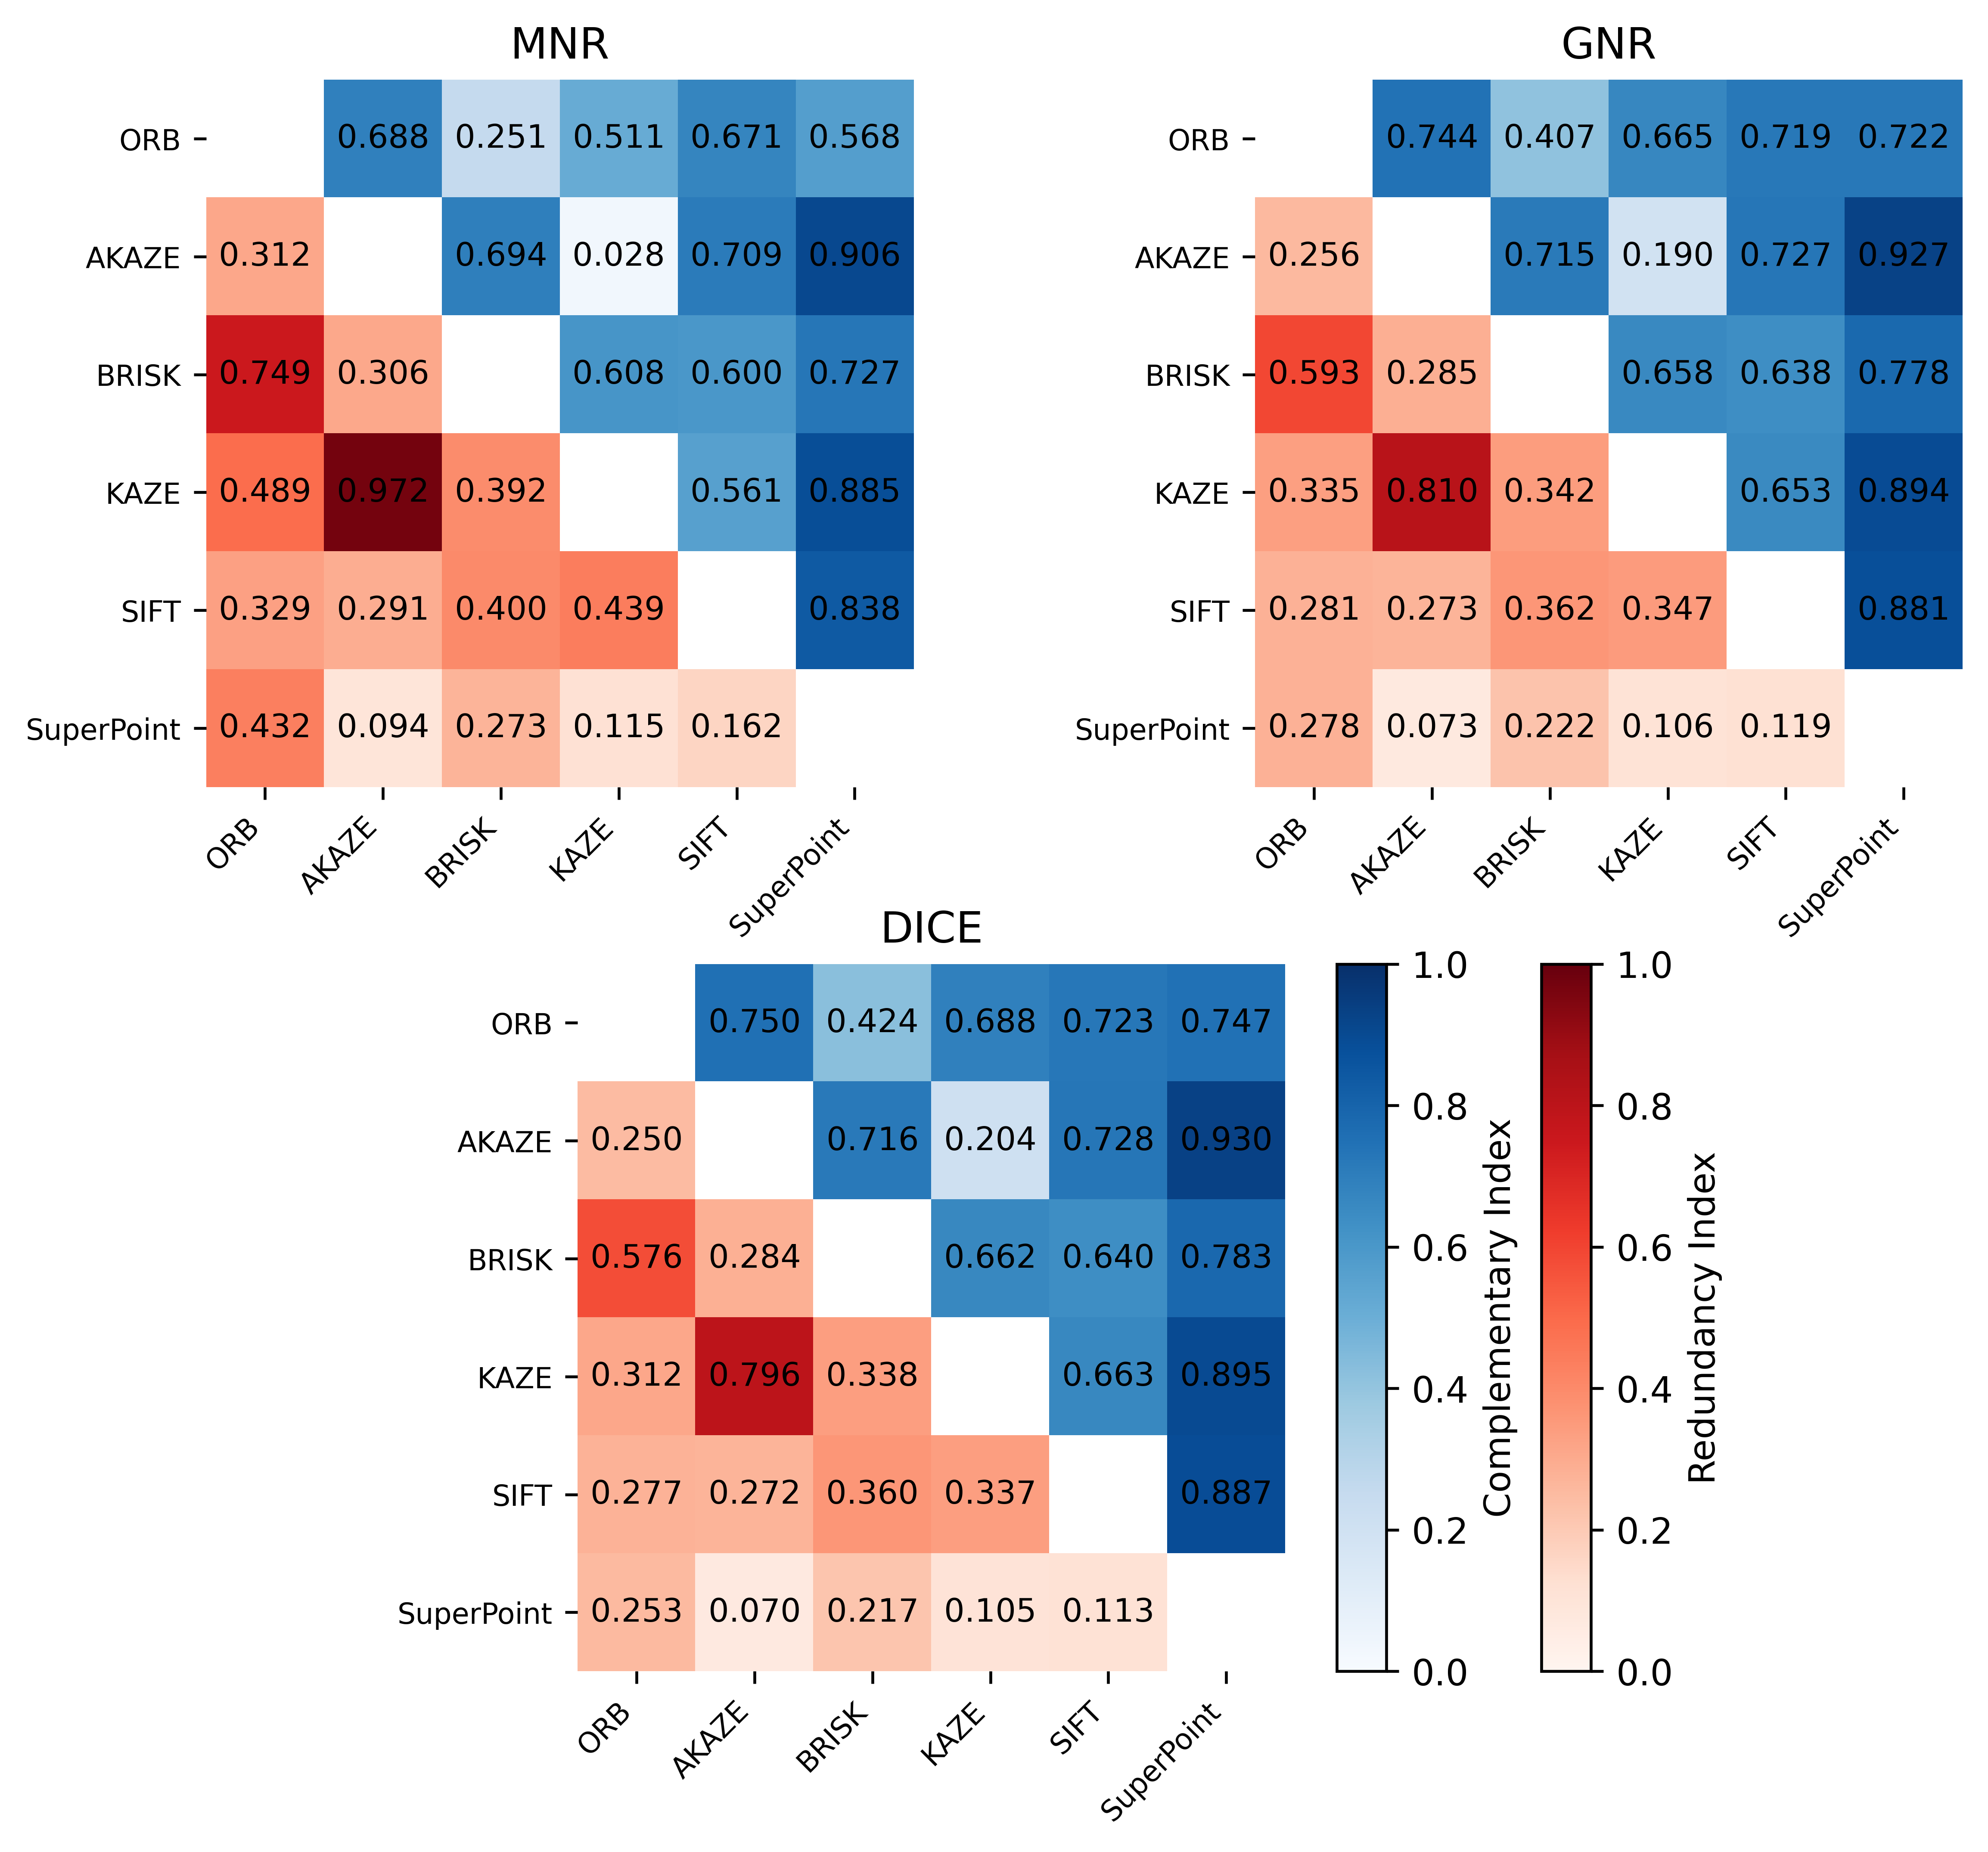

In [110]:
RAW_FILE = 'Correlations/corr_exp_fr2_corr.txt'
OUT_DIR  = Path('ResultFigs')
OUT_DIR.mkdir(exist_ok=True)

with open(RAW_FILE, 'r', encoding='utf-8') as f:
    txt = f.read()

blocks = re.split(r'#\s*-+\s*\d+\s*Per-Channel Summary\s*-+\s*', txt)[1:]
dfs = [parse_block(b) for b in blocks]

avg_vals = compute_avg_metrics(dfs, channel_names, metrics)

ims_red, ims_blue = [], []

fig = plt.figure(figsize=(10, 8), dpi=600)
gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 1.0], hspace=0.25, wspace=0.10)

ax_mnr  = fig.add_subplot(gs[0, 0])
ax_gnr  = fig.add_subplot(gs[0, 1])
ax_dice = fig.add_subplot(gs[1, :])

for ax, m in [(ax_mnr, 'MNR'), (ax_gnr, 'GNR'), (ax_dice, 'DICE')]:
    ax.grid(False)
    ax.set_frame_on(False)
    im_blue, im_red = plot_metric(avg_vals[m], channel_names, m, ax)
    ims_blue.append(im_blue)
    ims_red.append(im_red)

divider  = make_axes_locatable(ax_dice)
cax_blue = divider.append_axes("right", size="7%", pad=0.2)
cax_red  = divider.append_axes("right", size="7%", pad=0.6)

cb_blue = fig.colorbar(ims_blue[-1], cax=cax_blue, orientation="vertical")
cb_blue.set_label("Complementary Index")
cb_red  = fig.colorbar(ims_red[-1],  cax=cax_red,  orientation="vertical")
cb_red.set_label("Redundancy Index")

for a in (ax_mnr, ax_gnr, ax_dice):
    a.tick_params(labelsize=8)

fig.savefig(OUT_DIR/'corr_exp_fr2xyz.png', dpi=600, bbox_inches='tight')
plt.show()

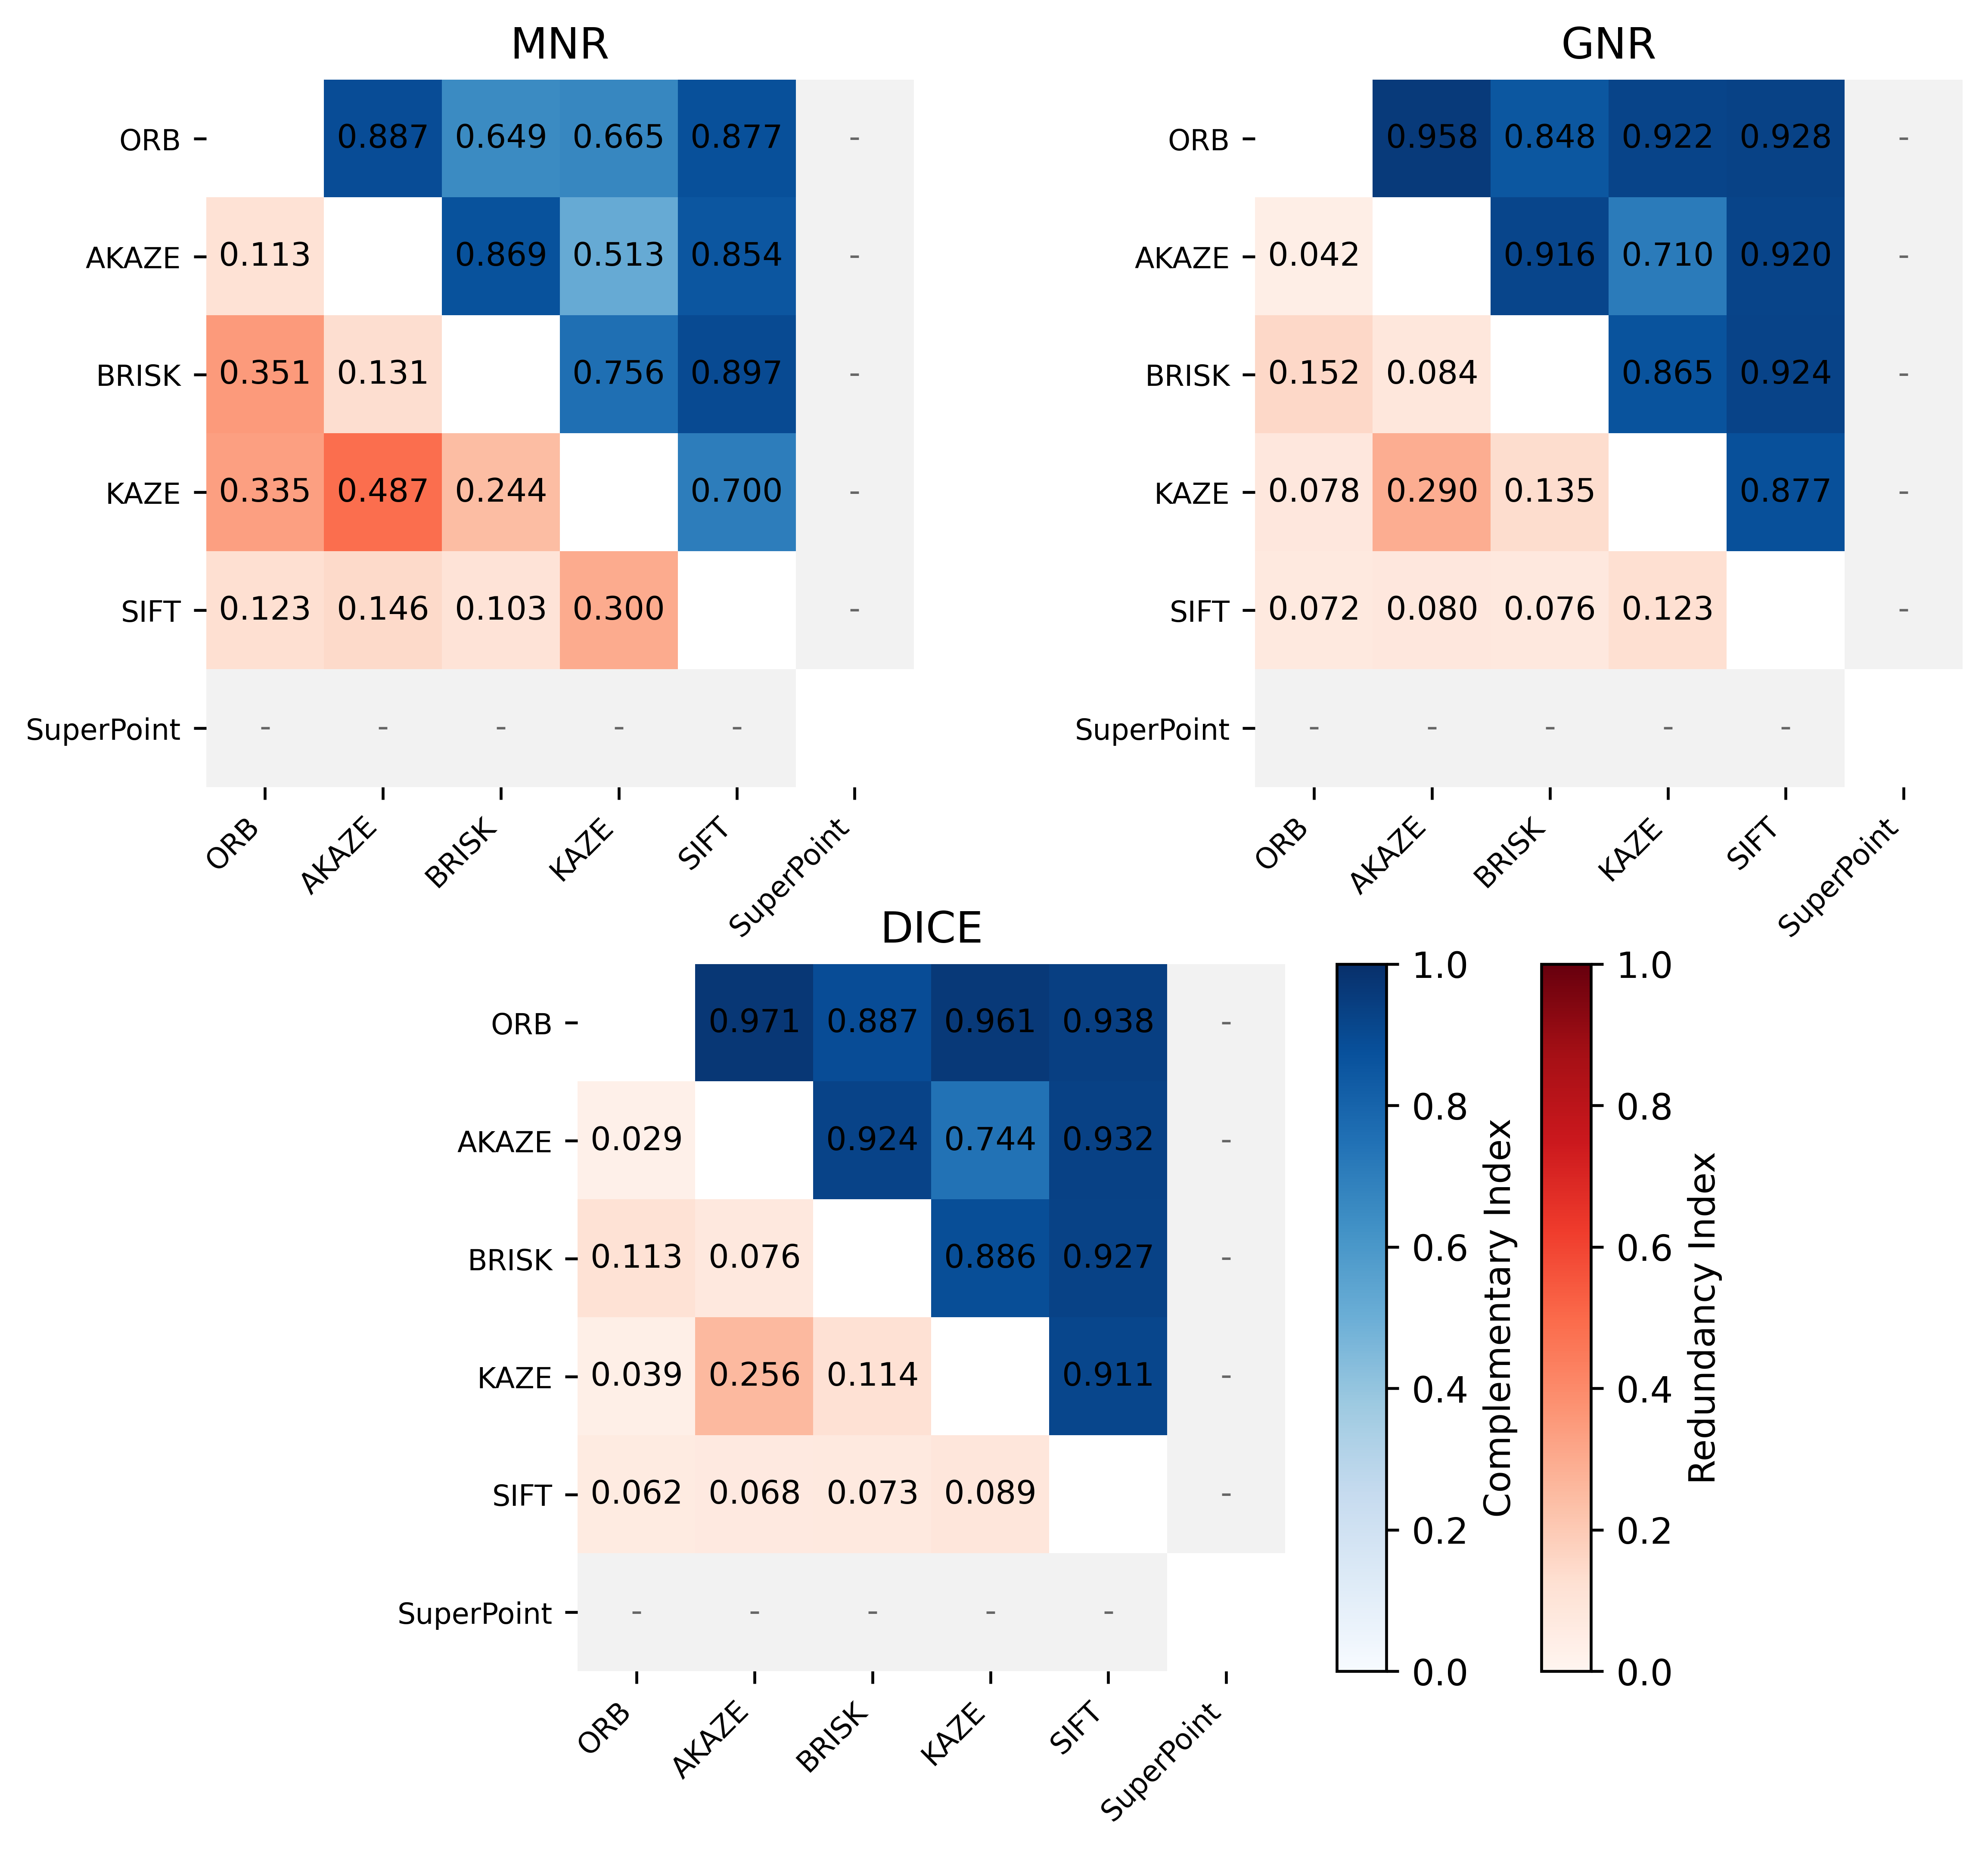

In [111]:
RAW_FILE = 'Correlations/corr_exp_fr3_corr.txt'
OUT_DIR  = Path('ResultFigs')
OUT_DIR.mkdir(exist_ok=True)

with open(RAW_FILE, 'r', encoding='utf-8') as f:
    txt = f.read()

blocks = re.split(r'#\s*-+\s*\d+\s*Per-Channel Summary\s*-+\s*', txt)[1:]
dfs = [parse_block(b) for b in blocks]

avg_vals = compute_avg_metrics(dfs, channel_names, metrics)

ims_red, ims_blue = [], []

fig = plt.figure(figsize=(10, 8), dpi=600)
gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 1.0], hspace=0.25, wspace=0.10)

ax_mnr  = fig.add_subplot(gs[0, 0])
ax_gnr  = fig.add_subplot(gs[0, 1])
ax_dice = fig.add_subplot(gs[1, :])

for ax, m in [(ax_mnr, 'MNR'), (ax_gnr, 'GNR'), (ax_dice, 'DICE')]:
    ax.grid(False)
    ax.set_frame_on(False)
    im_blue, im_red = plot_metric(avg_vals[m], channel_names, m, ax)
    ims_blue.append(im_blue)
    ims_red.append(im_red)

divider  = make_axes_locatable(ax_dice)
cax_blue = divider.append_axes("right", size="7%", pad=0.2)
cax_red  = divider.append_axes("right", size="7%", pad=0.6)

cb_blue = fig.colorbar(ims_blue[-1], cax=cax_blue, orientation="vertical")
cb_blue.set_label("Complementary Index")
cb_red  = fig.colorbar(ims_red[-1],  cax=cax_red,  orientation="vertical")
cb_red.set_label("Redundancy Index")

for a in (ax_mnr, ax_gnr, ax_dice):
    a.tick_params(labelsize=8)

fig.savefig(OUT_DIR/'corr_exp_fr3nnf.png', dpi=600, bbox_inches='tight')
plt.show()